# **Introduction**

- This workbook attempts to construct a Convlutional Neural Network to classify COVID-19 and Pneumonia using chest x-ray images.

# **Setup**

- Import required packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# **Generate a `Dataset`**

In [2]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5144 files belonging to 3 classes.
Using 4116 files for training.


2022-04-24 15:11:46.650133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 15:11:46.736087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 15:11:46.736905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 15:11:46.738974: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 5144 files belonging to 3 classes.
Using 1028 files for validation.


In [3]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/test",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1288 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


In [43]:
# import required module
import os
# assign directory
directory = '../input/chest-xray-covid19-pneumonia/Data/test'
 
# iterate over files in
# that directory
y_label=[]
for filename in os.listdir(directory):
    #print(filename)
    for file in os.listdir(os.path.join(directory, filename)):
        #print(file)
        y_label.append(filename)
print(y_label)

['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA'

# **Visualize the Data**
- First 9 Images from the dataset

2022-04-24 15:12:11.864244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


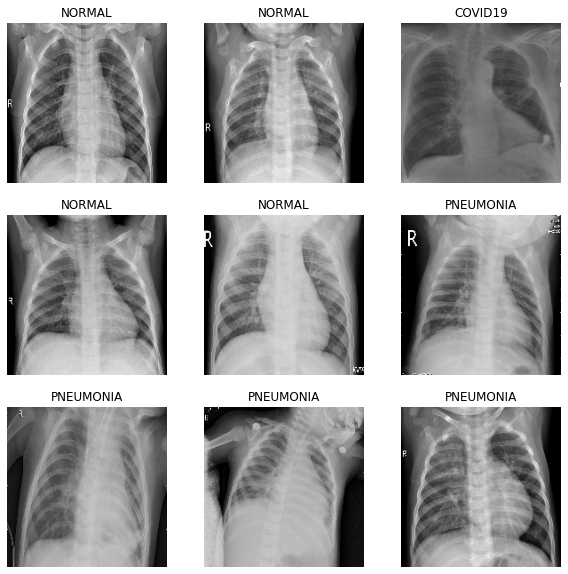

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Image Data Augmentation**

In [7]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

- The images after random augmentation

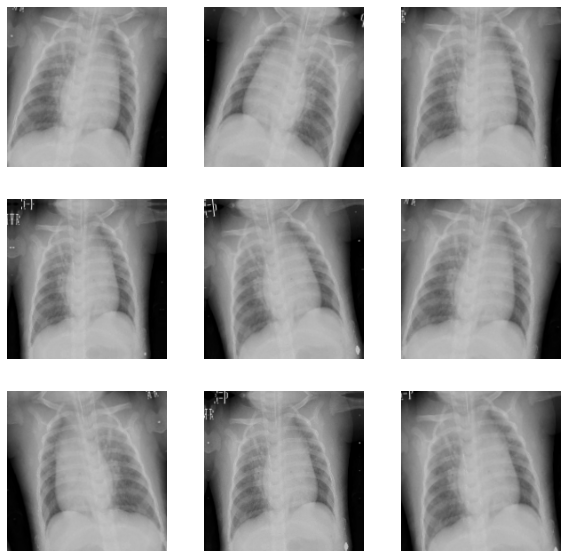

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Configure the dataset for performance**

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

# **Build Model**

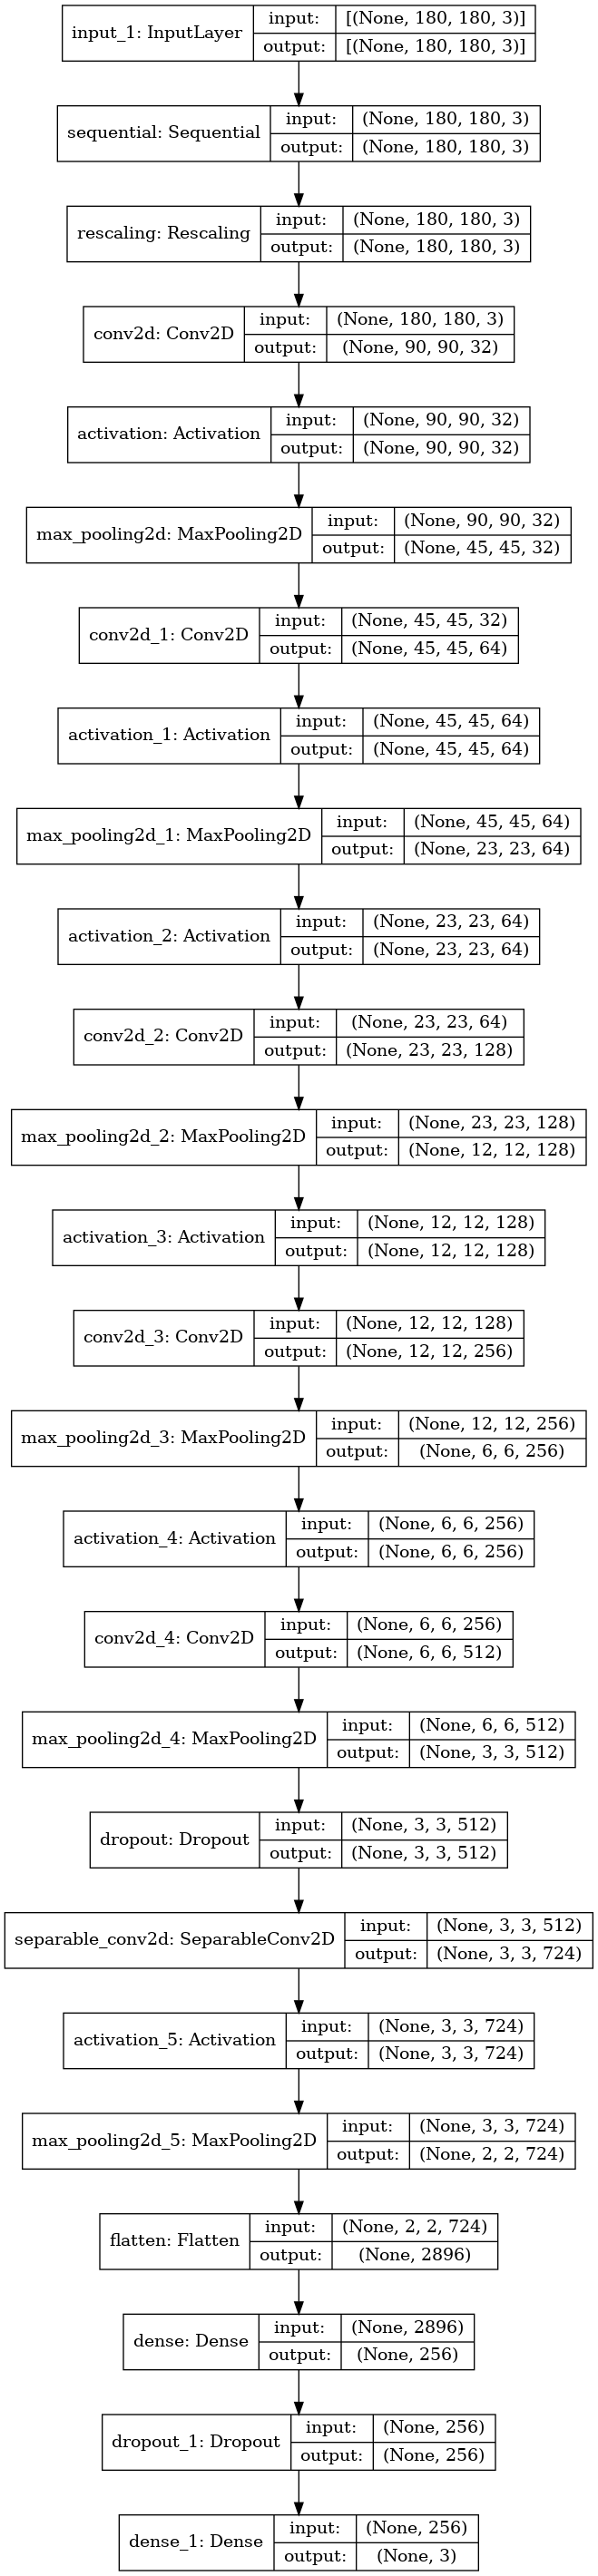

In [10]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

# **Define Callbacks**

In [11]:
# checkpoint_filepath = '/content/content'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=6,
#     verbose=0,
#     restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# **Train the Model**

In [13]:
epochs = 15

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/15
129/129 [==============================] - 39s 274ms/step - loss: 0.5786 - accuracy: 0.7553 - val_loss: 0.4282 - val_accuracy: 0.8337
Epoch 2/15
129/129 [==============================] - 36s 270ms/step - loss: 0.3623 - accuracy: 0.8693 - val_loss: 0.2529 - val_accuracy: 0.9018
Epoch 3/15
129/129 [==============================] - 37s 274ms/step - loss: 0.3141 - accuracy: 0.8914 - val_loss: 0.2541 - val_accuracy: 0.9018
Epoch 4/15
129/129 [==============================] - 36s 270ms/step - loss: 0.2579 - accuracy: 0.9040 - val_loss: 0.1801 - val_accuracy: 0.9358
Epoch 5/15
129/129 [==============================] - 36s 271ms/step - loss: 0.2487 - accuracy: 0.9138 - val_loss: 0.2389 - val_accuracy: 0.9095
Epoch 6/15
129/129 [==============================] - 36s 269ms/step - loss: 0.2395 - accuracy: 0.9167 - val_loss: 0.1694 - val_accuracy: 0.9397
Epoch 7/15
129/129 [==============================] - 37s 274ms/step - loss: 0.2024 - accuracy: 0.9271 - val_loss: 0.1964 - val_ac

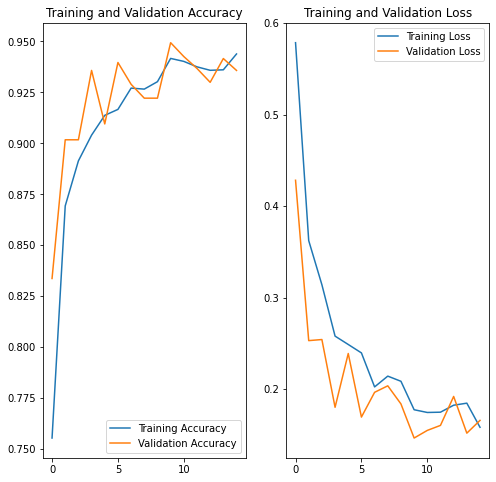

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
evaluation = model.evaluate(test_ds)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_ds)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

41/41 [==============================] - 14s 261ms/step - loss: 0.1602 - accuracy: 0.9425
Test Accuracy: 94.25%
129/129 [==============================] - 28s 207ms/step - loss: 0.1448 - accuracy: 0.9478
Train Accuracy: 94.78%


In [32]:
prediction=model.predict(test_ds)

In [48]:
pred_path=[]
y_pred=[]
y_label=[]
for filename in os.listdir(directory):
    #print(filename)
    for file in os.listdir(os.path.join(directory, filename)):
        #print(file)
        pred_path.append(os.path.join(directory, filename, file))
        y_label.append(filename)

for img_path in pred_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred.append(class_names[np.argmax(score)])
       

['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', '

In [49]:
print(y_label)

['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA'

In [50]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_label, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[109   2   5]
 [  1 265  51]
 [  0  15 840]]


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_label, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['COVID19', 'NORMAL', 'PNEUMONIA']))


Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.96
Macro Recall: 0.92
Macro F1-score: 0.94

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94

Classification Report

              precision    recall  f1-score   support

     COVID19       0.99      0.94      0.96       116
      NORMAL       0.94      0.84      0.88       317
   PNEUMONIA       0.94      0.98      0.96       855

    accuracy                           0.94      1288
   macro avg       0.96      0.92      0.94      1288
weighted avg       0.94      0.94      0.94      1288



### Transfer Learning

In [25]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 90, 90, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1/conv[0][0]                 
_______________________

In [26]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [27]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [28]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(3, activation="softmax")(x)

dense_model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

dense_model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

In [29]:
print(f"The input shape {model.input}")
print(f"The output shape {model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


In [59]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, epsilon=1e-4, mode='min')

In [61]:
r=dense_model.fit(train_ds, epochs=15,validation_data = val_ds, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/15
129/129 [==============================] - 44s 327ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.1585 - val_accuracy: 0.9591
Epoch 2/15
129/129 [==============================] - 43s 324ms/step - loss: 0.0165 - accuracy: 0.9939 - val_loss: 0.1700 - val_accuracy: 0.9640
Epoch 3/15
129/129 [==============================] - 43s 323ms/step - loss: 0.0569 - accuracy: 0.9791 - val_loss: 0.6926 - val_accuracy: 0.8317
Epoch 4/15
129/129 [==============================] - 44s 327ms/step - loss: 0.0181 - accuracy: 0.9951 - val_loss: 0.1443 - val_accuracy: 0.9630
Epoch 5/15
129/129 [==============================] - 44s 331ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.1203 - val_accuracy: 0.9708
Epoch 6/15
129/129 [==============================] - 44s 327ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1187 - val_accuracy: 0.9698
Epoch 7/15
129/129 [==============================] - 44s 328ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.1196 - val_ac

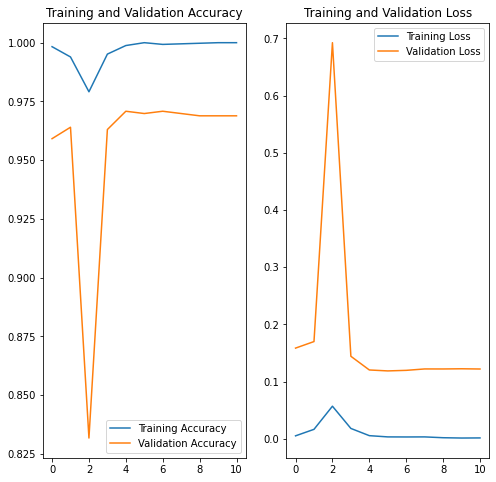

In [63]:
accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
evaluation = dense_model.evaluate(test_ds)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = dense_model.evaluate(train_ds)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

41/41 [==============================] - 10s 191ms/step - loss: 0.1075 - accuracy: 0.9728
Test Accuracy: 97.28%
129/129 [==============================] - 30s 224ms/step - loss: 4.4165e-04 - accuracy: 1.0000
Train Accuracy: 100.00%


In [66]:
pred_path=[]
y_label=[]
y_pred_dense=[]
for filename in os.listdir(directory):
    #print(filename)
    for file in os.listdir(os.path.join(directory, filename)):
        #print(file)
        pred_path.append(os.path.join(directory, filename, file))
        y_label.append(filename)

for img_path in pred_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = dense_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred_dense.append(class_names[np.argmax(score)])
       

In [67]:
confusion = confusion_matrix(y_label, y_pred_dense)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[116   0   0]
 [  0 306  11]
 [  0  24 831]]


In [68]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_label, y_pred_dense)))

print('Micro Precision: {:.2f}'.format(precision_score(y_label, y_pred_dense, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_label, y_pred_dense, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred_dense, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_label, y_pred_dense, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_label, y_pred_dense, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred_dense, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_label, y_pred_dense, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_label, y_pred_dense, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_label, y_pred_dense, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_label, y_pred_dense, target_names=['COVID19', 'NORMAL', 'PNEUMONIA']))


Accuracy: 0.97

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.97
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97

Classification Report

              precision    recall  f1-score   support

     COVID19       1.00      1.00      1.00       116
      NORMAL       0.93      0.97      0.95       317
   PNEUMONIA       0.99      0.97      0.98       855

    accuracy                           0.97      1288
   macro avg       0.97      0.98      0.98      1288
weighted avg       0.97      0.97      0.97      1288



### VGG16

In [69]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16


vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(180,180,3))
for layers in vgg16_model.layers:
            layers.trainable=False

58900480/58889256 [==============================] - 0s 0us/step


In [70]:
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [71]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, epsilon=1e-4, mode='min')

In [72]:
r=vgg16_final_model.fit(train_ds, epochs=15,validation_data = val_ds, 
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/15
129/129 [==============================] - 40s 279ms/step - loss: 0.3323 - acc: 0.9001 - val_loss: 0.2256 - val_acc: 0.9163
Epoch 2/15
129/129 [==============================] - 37s 275ms/step - loss: 0.1603 - acc: 0.9446 - val_loss: 0.1740 - val_acc: 0.9348
Epoch 3/15
129/129 [==============================] - 37s 277ms/step - loss: 0.1138 - acc: 0.9599 - val_loss: 0.1841 - val_acc: 0.9358
Epoch 4/15
129/129 [==============================] - 37s 278ms/step - loss: 0.0814 - acc: 0.9691 - val_loss: 0.1621 - val_acc: 0.9475
Epoch 5/15
129/129 [==============================] - 37s 276ms/step - loss: 0.0715 - acc: 0.9757 - val_loss: 0.1486 - val_acc: 0.9455
Epoch 6/15
129/129 [==============================] - 37s 276ms/step - loss: 0.0531 - acc: 0.9801 - val_loss: 0.1690 - val_acc: 0.9475
Epoch 7/15
129/129 [==============================] - 36s 270ms/step - loss: 0.0680 - acc: 0.9742 - val_loss: 0.1677 - val_acc: 0.9455
Epoch 8/15
129/129 [==============================] - 3

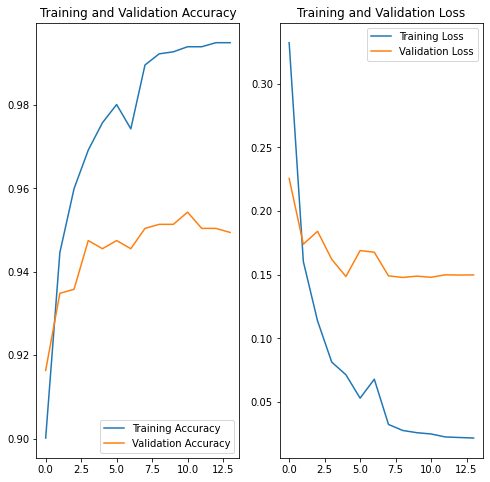

In [75]:
accuracy = r.history['acc']
val_accuracy = r.history['val_acc']

loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [74]:
evaluation = vgg16_final_model.evaluate(test_ds)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_final_model.evaluate(train_ds)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

41/41 [==============================] - 10s 201ms/step - loss: 0.1345 - acc: 0.9542
Test Accuracy: 95.42%
129/129 [==============================] - 30s 218ms/step - loss: 0.0217 - acc: 0.9951
Train Accuracy: 99.51%


In [76]:
pred_path=[]
y_label=[]
y_pred_vgg=[]
for filename in os.listdir(directory):
    #print(filename)
    for file in os.listdir(os.path.join(directory, filename)):
        #print(file)
        pred_path.append(os.path.join(directory, filename, file))
        y_label.append(filename)

for img_path in pred_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = vgg16_final_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred_vgg.append(class_names[np.argmax(score)])

In [77]:
confusion = confusion_matrix(y_label, y_pred_vgg)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[110   2   4]
 [  1 292  24]
 [  0  27 828]]


In [78]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_label, y_pred_vgg)))

print('Micro Precision: {:.2f}'.format(precision_score(y_label, y_pred_vgg, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_label, y_pred_vgg, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred_vgg, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_label, y_pred_vgg, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_label, y_pred_vgg, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred_vgg, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_label, y_pred_vgg, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_label, y_pred_vgg, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_label, y_pred_vgg, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_label, y_pred_vgg, target_names=['COVID19', 'NORMAL', 'PNEUMONIA']))


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.96
Macro Recall: 0.95
Macro F1-score: 0.95

Weighted Precision: 0.96
Weighted Recall: 0.95
Weighted F1-score: 0.96

Classification Report

              precision    recall  f1-score   support

     COVID19       0.99      0.95      0.97       116
      NORMAL       0.91      0.92      0.92       317
   PNEUMONIA       0.97      0.97      0.97       855

    accuracy                           0.95      1288
   macro avg       0.96      0.95      0.95      1288
weighted avg       0.96      0.95      0.96      1288



### ResNet50

In [79]:
from tensorflow.keras.applications import ResNet50

ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180,180,3), classes=3)

94781440/94765736 [==============================] - 1s 0us/step


In [85]:
resnet_model = tf.keras.Sequential([
        ResNet50_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3,activation="softmax")
    ])
opt = keras.optimizers.SGD()
resnet_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['acc'])

In [86]:
r=resnet_model.fit(train_ds, epochs=15,validation_data = val_ds, 
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/15
129/129 [==============================] - 48s 328ms/step - loss: 0.4713 - acc: 0.8345 - val_loss: 0.3941 - val_acc: 0.8589
Epoch 2/15
129/129 [==============================] - 42s 318ms/step - loss: 0.2433 - acc: 0.9303 - val_loss: 0.4422 - val_acc: 0.8414
Epoch 3/15
129/129 [==============================] - 43s 320ms/step - loss: 0.1982 - acc: 0.9436 - val_loss: 0.3151 - val_acc: 0.8872
Epoch 4/15
129/129 [==============================] - 42s 313ms/step - loss: 0.1491 - acc: 0.9597 - val_loss: 0.1635 - val_acc: 0.9475
Epoch 5/15
129/129 [==============================] - 43s 321ms/step - loss: 0.1212 - acc: 0.9645 - val_loss: 0.1523 - val_acc: 0.9475
Epoch 6/15
129/129 [==============================] - 42s 311ms/step - loss: 0.1118 - acc: 0.9706 - val_loss: 0.3119 - val_acc: 0.8920
Epoch 7/15
129/129 [==============================] - 42s 314ms/step - loss: 0.0980 - acc: 0.9752 - val_loss: 0.3386 - val_acc: 0.8949
Epoch 8/15
129/129 [==============================] - 4

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
129/129 [==============================] - 42s 315ms/step - loss: 0.0796 - acc: 0.9815 - val_loss: 0.1035 - val_acc: 0.9708
Epoch 10/15
129/129 [==============================] - 42s 316ms/step - loss: 0.0772 - acc: 0.9798 - val_loss: 0.1044 - val_acc: 0.9708
Epoch 11/15
129/129 [==============================] - 42s 316ms/step - loss: 0.0719 - acc: 0.9810 - val_loss: 0.1110 - val_acc: 0.9650
Epoch 12/15
129/129 [==============================] - 42s 318ms/step - loss: 0.0658 - acc: 0.9820 - val_loss: 0.1073 - val_acc: 0.9669
Epoch 13/15
129/129 [==============================] - 42s 314ms/step - loss: 0.0577 - acc: 0.9866 - val_loss: 0.1061 - val_acc: 0.9679
Epoch 14/15
129/129 [==============================] - 42s 317ms/step - loss: 0.0599 - acc: 0.9830 - val_loss: 0.1062 - val_acc: 0.9679


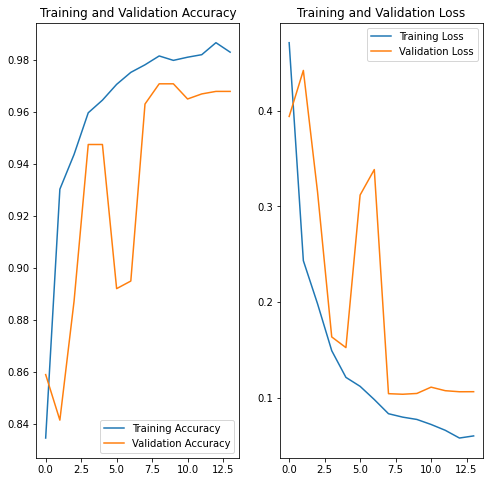

In [88]:
accuracy = r.history['acc']
val_accuracy = r.history['val_acc']

loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
evaluation = resnet_model.evaluate(test_ds)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train_ds)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

41/41 [==============================] - 11s 212ms/step - loss: 0.1235 - acc: 0.9635
Test Accuracy: 96.35%
129/129 [==============================] - 30s 220ms/step - loss: 0.0186 - acc: 0.9961
Train Accuracy: 99.61%


In [92]:
pred_path=[]
y_label=[]
y_pred_resnet=[]
for filename in os.listdir(directory):
    #print(filename)
    for file in os.listdir(os.path.join(directory, filename)):
        #print(file)
        pred_path.append(os.path.join(directory, filename, file))
        y_label.append(filename)

for img_path in pred_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = resnet_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred_resnet.append(class_names[np.argmax(score)])

In [93]:
confusion = confusion_matrix(y_label, y_pred_resnet)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[112   2   2]
 [  0 293  24]
 [  0  17 838]]


In [94]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_label, y_pred_resnet)))

print('Micro Precision: {:.2f}'.format(precision_score(y_label, y_pred_resnet, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_label, y_pred_resnet, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred_resnet, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_label, y_pred_resnet, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_label, y_pred_resnet, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_label, y_pred_resnet, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_label, y_pred_resnet, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_label, y_pred_resnet, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_label, y_pred_resnet, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_label, y_pred_resnet, target_names=['COVID19', 'NORMAL', 'PNEUMONIA']))


Accuracy: 0.97

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.97
Macro Recall: 0.96
Macro F1-score: 0.96

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.96

Classification Report

              precision    recall  f1-score   support

     COVID19       1.00      0.97      0.98       116
      NORMAL       0.94      0.92      0.93       317
   PNEUMONIA       0.97      0.98      0.97       855

    accuracy                           0.97      1288
   macro avg       0.97      0.96      0.96      1288
weighted avg       0.97      0.97      0.96      1288

